This is the demonstration for single-domain transfer learning behaviour of models. If the implementation is a valid GP, then it should finish this simple task with ease.

***Note:*** This notebook and "Multi_Domain_Toy_Dataset.ipynb" both contains isolated implementation for models and kernels, which is different than those given in /utils. The implementation used here are in fact earlier version of the kernels. When the implementation iterates into those in /utils, it was found that there was no elegant solution to make the kernel and, especially the model, to be compatible to both medical data and toy data. Therefore, the implemetation here was left as it was. Still, the idea of both versions of implemetation is the same. 

In [16]:
import math
import torch
import gpytorch
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Toy data generation

In [17]:
    
# Training data is 100 points in [0,1] inclusive regularly spaced
X_train_tensor = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
y_train_tensor = torch.sin(X_train_tensor * (2 * math.pi)) + torch.randn(X_train_tensor.size()) * math.sqrt(0.04)

X_test_tensor = torch.linspace(0, 1, 100)
num_conc=1
num_feat=1

In [18]:
print(X_test_tensor.shape)
print(X_train_tensor.shape)

torch.Size([100])
torch.Size([100])


# Example models & kernels

The example kernel and model to play with. They are very old implementation in very initial stage of the research, but still an adequate example for GP.

In [19]:
class QuadripleDRPKernel(Kernel):
    def __init__(self,filters, **kwargs):
        super().__init__(**kwargs)
        self.kernel_mu = gpytorch.kernels.RBFKernel()
        self.kernel_met = gpytorch.kernels.RBFKernel()
        self.kernel_cn = gpytorch.kernels.RBFKernel()
        # self.kernel_dc = gpytorch.kernels.RBFKernel()
        self.filter_mu,self.filter_met,self.filter_cn,self.filter_dc=filters
        
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # Apply the base kernel
        filter_mu=self.filter_mu
        filter_met=self.filter_met
        filter_cn=self.filter_cn
        filter_dc=self.filter_dc
        
        x1_mu   =   x1 @ filter_mu
        x1_met  =   x1 @ filter_met
        x1_cn   =   x1 @ filter_cn
        x1_dc   =   x1 @ filter_dc

        x2_mu   =   x2 @ filter_mu
        x2_met  =   x2 @ filter_met
        x2_cn   =   x2 @ filter_cn
        x2_dc   =   x2 @ filter_dc
        bias=torch.ones(x1.shape[0], x2.shape[0])
        return self.kernel_mu(x1_mu,x2_mu)*self.kernel_met(x1_met,x2_met)*self.kernel_cn(x1_cn,x2_cn)* 1#self.kernel_dc(x1_dc,x2_dc)

In [20]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,filters, likelihood,):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_conc
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
           QuadripleDRPKernel(filters), num_tasks=num_conc
        )
        
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_conc])), num_tasks=num_conc
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

class Linear_Model_Of_Corregionalization(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,likelihood,):
        super(Linear_Model_Of_Corregionalization, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=1
        )
        kernels=[]
        for _ in range(1):
            kernels.append(gpytorch.kernels.RBFKernel())

        self.covar_module =gpytorch.kernels.LCMKernel(
            kernels, num_tasks=1, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


# The training block

In [21]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=1)
model = Linear_Model_Of_Corregionalization(X_train_tensor, y_train_tensor, likelihood)


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.18)

# defines the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
last_loss=1
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    this_loss=loss.item()
    optimizer.step()  # 更新参数
    scheduler.step()  # 更新学习率
    if abs((last_loss-this_loss)/last_loss)<0.001:
        pass
    last_loss=this_loss

Iter 1/200 - Loss: 1.208
Iter 2/200 - Loss: 1.149
Iter 3/200 - Loss: 1.084
Iter 4/200 - Loss: 1.009
Iter 5/200 - Loss: 0.929
Iter 6/200 - Loss: 0.854
Iter 7/200 - Loss: 0.785
Iter 8/200 - Loss: 0.718
Iter 9/200 - Loss: 0.650
Iter 10/200 - Loss: 0.579
Iter 11/200 - Loss: 0.506
Iter 12/200 - Loss: 0.434
Iter 13/200 - Loss: 0.362
Iter 14/200 - Loss: 0.294
Iter 15/200 - Loss: 0.232
Iter 16/200 - Loss: 0.178
Iter 17/200 - Loss: 0.129
Iter 18/200 - Loss: 0.081
Iter 19/200 - Loss: 0.039
Iter 20/200 - Loss: 0.005
Iter 21/200 - Loss: -0.019
Iter 22/200 - Loss: -0.032
Iter 23/200 - Loss: -0.035
Iter 24/200 - Loss: -0.030
Iter 25/200 - Loss: -0.019
Iter 26/200 - Loss: -0.005
Iter 27/200 - Loss: 0.010
Iter 28/200 - Loss: 0.022
Iter 29/200 - Loss: 0.031
Iter 30/200 - Loss: 0.034
Iter 31/200 - Loss: 0.031
Iter 32/200 - Loss: 0.022
Iter 33/200 - Loss: 0.011
Iter 34/200 - Loss: -0.002
Iter 35/200 - Loss: -0.013
Iter 36/200 - Loss: -0.022
Iter 37/200 - Loss: -0.029
Iter 38/200 - Loss: -0.034
Iter 39/20

# The plotting

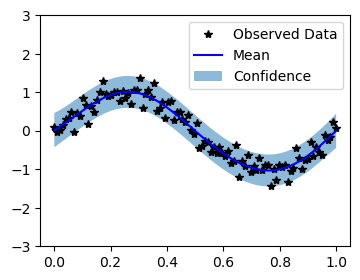

In [22]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train_tensor.numpy(), y_train_tensor.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])